# 📘 PROJECT: IT SALARY PREDICTION & SEGMENTATION
## FILE 1: ADVANCED DATA ENGINEERING & WAREHOUSING

**Mục tiêu:** Xử lý dữ liệu thô crawl từ web thành dữ liệu sạch, chất lượng cao, lưu trữ vào SQL Database.

### 🚀 Quy trình kỹ thuật (Technical Pipeline):
1. **Exploratory Data Analysis (EDA):** Phân tích sơ bộ cấu trúc dữ liệu.
2. **Advanced Cleaning (Regex):** Bóc tách lương (Min, Max, Avg) và quy đổi ngoại tệ.
3. **Missing Value Imputation (KNN):** Sử dụng thuật toán K-Nearest Neighbors để điền lương "Thỏa thuận" dựa trên sự tương đồng của công ty và địa điểm.
4. **Outlier Detection (IQR Method):** Loại bỏ các mức lương ảo/nhiễu bằng phương pháp thống kê.
5. **Data Warehousing (SQLite):** Lưu trữ dữ liệu sạch vào Database chuẩn công nghiệp.

In [75]:
# --- 1. SETUP ENVIRONMENT ---
import pandas as pd
import numpy as np
import re
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện cho Machine Learning xử lý dữ liệu thiếu
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


---
## 1. LOAD DATA & INITIAL EDA (Phân tích khám phá ban đầu)
Trước khi clean, ta cần hiểu dữ liệu đang "bẩn" ở mức độ nào.

In [76]:
# Đọc dữ liệu thô (Giả sử bạn đã có file csv từ bước Crawl)
try:
    df = pd.read_csv('jobs_it.csv')
    print(f"📊 Kích thước dữ liệu gốc: {df.shape[0]} dòng, {df.shape[1]} cột")
except FileNotFoundError:
    print("❌ Không tìm thấy file 'jobs_it.csv'. Hãy chắc chắn bạn đã crawl dữ liệu.")

# Xem 5 dòng đầu
display(df.head())

📊 Kích thước dữ liệu gốc: 1070 dòng, 4 cột


,Job Title,Company,Salary,Location
0,Trưởng nhóm Lập trình Java (tham gia các cuộc thi trong và ngoài nước về lập trình) (MỚI),Tổng Công ty Cổ phần Công trình Viettel,Lương: 30 Tr - 40 Tr VND,Hà Nội
1,Network Engineer - Kỹ Sư Mạng (Không Yêu Cầu Kinh Nghiệm),KDDI Vietnam - HCM GNOC (Ho Chi Minh Global Network Operations Center),Lương: 11 Tr - 13 Tr VND,Hồ Chí Minh
2,Quality Assurance Manager (Test Automation Manager),Công Ty CP Dược Phẩm Pharmacity,Lương: Cạnh tranh,Hồ Chí Minh
3,ELV Engineer - Kỹ Sư Điện Nhẹ,Công Ty Cổ Phần Netcab,Lương: 10 Tr - 18 Tr VND,Hà Nội
4,Threat and Process Compliance Lead,Coca-Cola Beverages Vietnam,Lương: Cạnh tranh,Hồ Chí Minh


In [77]:
# Kiểm tra thông tin tổng quan và dữ liệu bị thiếu
print("\n--- INFO ---")
df.info()

print("\n--- KIỂM TRA DUPLICATES (BẢN GHI TRÙNG) ---")
num_dups = df.duplicated().sum()
print(f"Số lượng dòng trùng lặp: {num_dups}")

if num_dups > 0:
    df.drop_duplicates(inplace=True)
    print(f"✅ Đã xóa dòng trùng. Kích thước hiện tại: {df.shape}")


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Job Title  1070 non-null   object
 1   Company    1070 non-null   object
 2   Salary     1070 non-null   object
 3   Location   1070 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB

--- KIỂM TRA DUPLICATES (BẢN GHI TRÙNG) ---
Số lượng dòng trùng lặp: 0


---
## 2. ADVANCED CLEANING: SALARY PARSING (Xử lý cột Lương)
Đây là phần khó nhất. Cột `Salary` hiện tại là chuỗi (string) hỗn loạn.
**Thách thức:**
- Định dạng đa dạng: "10 - 20 Tr", "Up to 1000 USD", "Trên 15 Triệu", "Thỏa thuận".
- Đơn vị tiền tệ khác nhau: USD vs VND.

**Giải pháp:** Viết hàm `parse_salary` sử dụng **Regex** để đưa về cùng một hệ quy chiếu (Triệu VNĐ).

In [78]:
def parse_salary(salary_str):
    """
    Hàm phân tích chuỗi lương thành Min và Max (đơn vị: Triệu VNĐ)
    Input: "10 Tr - 20 Tr VND", "Up to 1000 USD"
    Output: (min_salary, max_salary)
    """
    if pd.isna(salary_str) or salary_str.strip() == "":
        return np.nan, np.nan

    salary_str = salary_str.lower().replace(",", "").replace(".", "") # Xóa dấu phẩy/chấm ngàn

    # Tỷ giá giả định (Có thể cập nhật)
    USD_RATE = 25000

    # Case 1: Lương "Thỏa thuận" hoặc "Cạnh tranh"
    if "thỏa thuận" in salary_str or "cạnh tranh" in salary_str or "negotiable" in salary_str:
        return np.nan, np.nan

    # Case 2: Phát hiện đơn vị tiền tệ
    is_usd = "usd" in salary_str or "$" in salary_str
    multiplier = 1
    if is_usd:
        multiplier = USD_RATE / 1000000 # Đổi ra triệu VND
    else:
        # Nếu là VND, thường là "triệu", "tr". Nếu con số < 100 thì mặc định là Triệu.
        # Nếu con số > 100000 thì có thể là VND đồng -> chia 1.000.000
        pass

    # Tìm tất cả các con số trong chuỗi
    # Pattern: Tìm số, có thể dính chữ 'tr' hoặc không
    numbers = re.findall(r'\d+', salary_str)
    numbers = [float(n) for n in numbers]

    if not numbers:
        return np.nan, np.nan

    # Xử lý Logic con số
    min_sal, max_sal = 0, 0

    # Logic chuẩn hóa về Triệu VND
    # Nếu số > 500 (thường là USD hoặc VND full số)
    # Nếu số < 500 (thường là Triệu VND)

    clean_nums = []
    for num in numbers:
        if is_usd:
            clean_nums.append(num * multiplier)
        else:
            if num >= 100000: # Ví dụ 20000000
                clean_nums.append(num / 1000000)
            else: # Ví dụ 20 (Triệu)
                clean_nums.append(num)

    if len(clean_nums) == 1:
        # Dạng "Up to X" hoặc "Trên X"
        if "up to" in salary_str or "dưới" in salary_str:
            min_sal = 0
            max_sal = clean_nums[0]
        else:
            min_sal = clean_nums[0]
            max_sal = clean_nums[0] # Coi như lương cứng
    elif len(clean_nums) >= 2:
        # Dạng "10 - 20"
        min_sal = min(clean_nums)
        max_sal = max(clean_nums)

    return min_sal, max_sal

# --- ÁP DỤNG VÀO DATAFRAME ---
df[['Min_Salary', 'Max_Salary']] = df['Salary'].apply(lambda x: pd.Series(parse_salary(x)))

# Tính lương trung bình
df['Avg_Salary'] = (df['Min_Salary'] + df['Max_Salary']) / 2

# Xem kết quả
print("Mẫu kết quả sau khi tách lương:")
display(df[['Salary', 'Min_Salary', 'Max_Salary', 'Avg_Salary']].head(10))

# Kiểm tra tỷ lệ thiếu dữ liệu lương (Thỏa thuận)
missing_pct = df['Avg_Salary'].isna().mean() * 100
print(f"\n⚠️ Tỷ lệ lương 'Thỏa thuận' (Missing): {missing_pct:.2f}%")

Mẫu kết quả sau khi tách lương:


,Salary,Min_Salary,Max_Salary,Avg_Salary
0,Lương: 30 Tr - 40 Tr VND,30.0,40.0,35.0
1,Lương: 11 Tr - 13 Tr VND,11.0,13.0,12.0
2,Lương: Cạnh tranh,NaN,NaN,NaN
3,Lương: 10 Tr - 18 Tr VND,10.0,18.0,14.0
4,Lương: Cạnh tranh,NaN,NaN,NaN
5,Lương: 15 Tr - 40 Tr VND,15.0,40.0,27.5
6,Lương: 30 Tr - 45 Tr VND,30.0,45.0,37.5
7,Lương: Cạnh tranh,NaN,NaN,NaN
8,Lương: 15 Tr - 40 Tr VND,15.0,40.0,27.5
9,Lương: 12 Tr - 30 Tr VND,12.0,30.0,21.0



⚠️ Tỷ lệ lương 'Thỏa thuận' (Missing): 57.38%


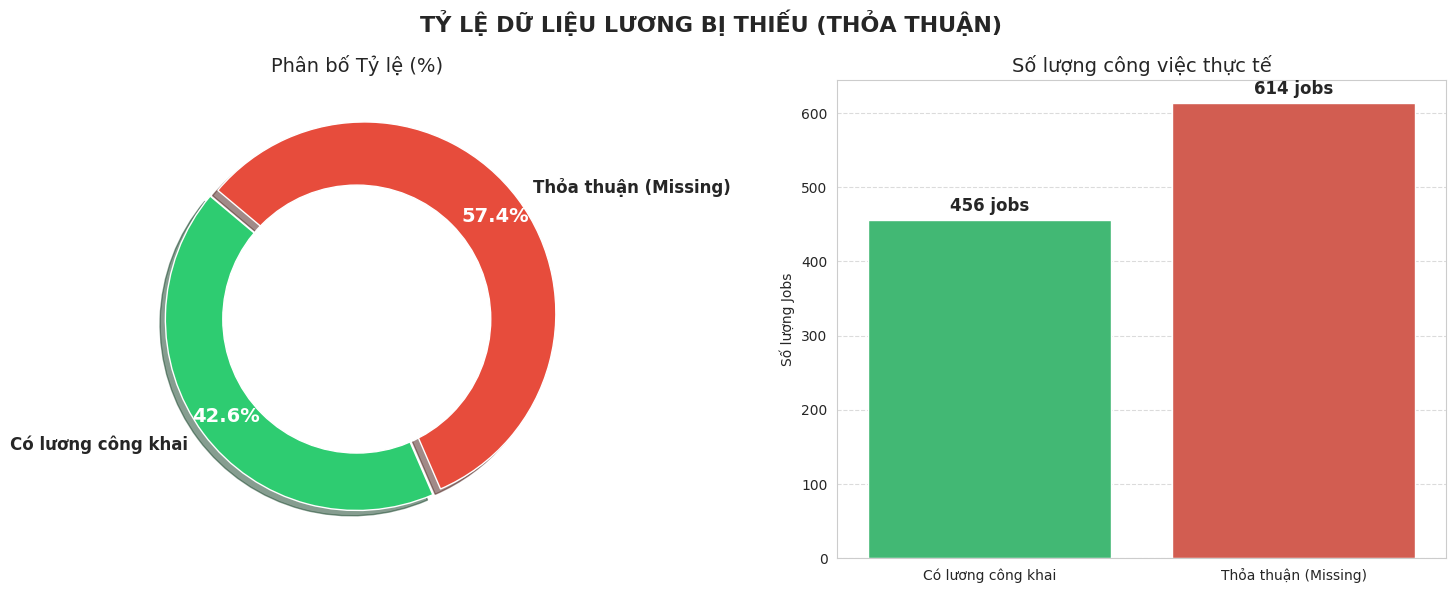

In [79]:
# --- VISUALIZATION: MISSING SALARY ANALYSIS ---

# 1. Chuẩn bị dữ liệu
missing_count = df['Avg_Salary'].isna().sum()
available_count = df['Avg_Salary'].notna().sum()
labels = ['Có lương công khai', 'Thỏa thuận (Missing)']
values = [available_count, missing_count]
colors = ['#2ecc71', '#e74c3c']  # Xanh (Tốt) - Đỏ (Thiếu)

# 2. Thiết lập khung hình
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('TỶ LỆ DỮ LIỆU LƯƠNG BỊ THIẾU (THỎA THUẬN)', fontsize=16, fontweight='bold')

# --- BIỂU ĐỒ 1: DONUT CHART (Tỷ lệ %) ---
wedges, texts, autotexts = ax[0].pie(values, labels=labels, autopct='%1.1f%%',
                                     startangle=140, colors=colors, pctdistance=0.85,
                                     explode=[0, 0.05], shadow=True)

# Tạo vòng tròn trắng ở giữa để thành Donut Chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[0].add_artist(centre_circle)

# Trang trí text
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

ax[0].set_title("Phân bố Tỷ lệ (%)", fontsize=14)

# --- BIỂU ĐỒ 2: BAR CHART (Số lượng tuyệt đối) ---
sns.barplot(x=labels, y=values, palette=colors, ax=ax[1])

# Thêm số liệu trên đầu cột
for i, v in enumerate(values):
    ax[1].text(i, v + (max(values)*0.01), str(f"{v:,} jobs"),
               ha='center', va='bottom', fontsize=12, fontweight='bold')

ax[1].set_title("Số lượng công việc thực tế", fontsize=14)
ax[1].set_ylabel("Số lượng Jobs")
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

---
## 3. ADVANCED IMPUTATION: KNN IMPUTER (Xử lý dữ liệu thiếu)

Thay vì xóa bỏ các dòng "Thỏa thuận" hoặc điền bằng Mean (cách sơ cấp), ta sẽ dùng **KNN Imputer**.

**Ý tưởng:** Tìm các công việc có đặc điểm tương đồng (Cùng địa điểm, cùng công ty, hoặc tần suất xuất hiện tương tự) để "đoán" lương.

> *Lưu ý: Để KNN hoạt động, ta cần biến đổi các cột Text (Location, Company) thành số. Ở đây tôi dùng kỹ thuật **Frequency Encoding** (Mã hóa tần suất) - một kỹ thuật nhẹ và hiệu quả cho Data Engineering.*

In [80]:
# Tạo bản sao để xử lý Imputation
df_impute = df.copy()

# 1. Frequency Encoding cho Location và Company
# (Biến tên thành số dựa trên độ phổ biến)
for col in ['Location', 'Company']:
    freq = df_impute[col].value_counts(normalize=True)
    df_impute[f'{col}_Freq'] = df_impute[col].map(freq)

# 2. Chuẩn bị dữ liệu cho KNN
# Ta dùng: Location_Freq, Company_Freq để dự đoán Avg_Salary
features_to_impute = ['Location_Freq', 'Company_Freq', 'Avg_Salary']
impute_data = df_impute[features_to_impute]

# 3. Khởi tạo KNN Imputer (k=5)
# weights='distance': Những điểm gần hơn sẽ có trọng số cao hơn
imputer = KNNImputer(n_neighbors=5, weights='distance')

print("⏳ Đang chạy KNN Imputer... (Việc này tốn chút thời gian tính toán khoảng cách)")
imputed_array = imputer.fit_transform(impute_data)

# 4. Gán lại giá trị đã điền vào DataFrame gốc
df['Avg_Salary_Imputed'] = imputed_array[:, 2] # Cột index 2 là Avg_Salary

# 5. Đánh dấu dòng nào là dữ liệu thực, dòng nào là được điền (Optional - tốt cho việc phân tích sau này)
df['Is_Imputed'] = df['Avg_Salary'].isna()

# Kiểm tra kết quả
print("\n✅ Đã điền xong lương thiếu. Ví dụ so sánh:")
display(df[df['Is_Imputed'] == True][['Job Title', 'Salary', 'Avg_Salary_Imputed']].head())

⏳ Đang chạy KNN Imputer... (Việc này tốn chút thời gian tính toán khoảng cách)

✅ Đã điền xong lương thiếu. Ví dụ so sánh:


,Job Title,Salary,Avg_Salary_Imputed
2,Quality Assurance Manager (Test Automation Manager),Lương: Cạnh tranh,25.6
4,Threat and Process Compliance Lead,Lương: Cạnh tranh,20.3
7,Senior Data Governance Officer,Lương: Cạnh tranh,21.8
10,Kỹ sư An toàn thông tin,Lương: Cạnh tranh,22.1
11,Software Development Officer,Lương: Cạnh tranh,12.8


---
## 4. OUTLIER DETECTION & REMOVAL (Lọc nhiễu)
Dữ liệu có thể có sai sót (VD: Lương 500 triệu/tháng cho Junior, hoặc lương 1 triệu). Ta dùng **IQR (Interquartile Range)** để cắt bỏ phần đuôi nhiễu.

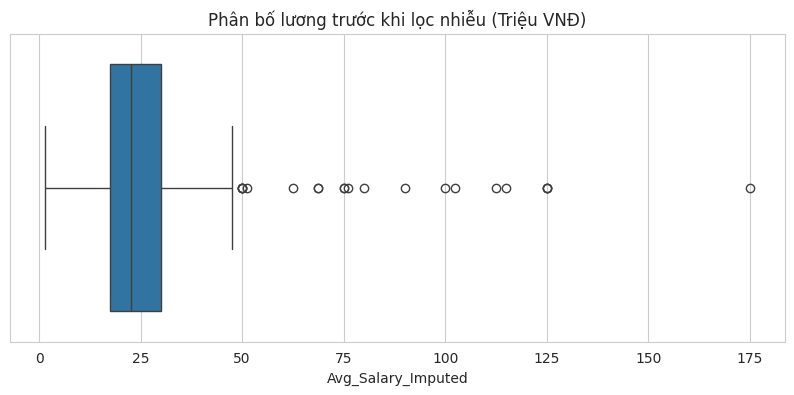

📉 Phạm vi chấp nhận: -1.33 -> 48.88 Triệu VNĐ
✅ Đã lọc nhiễu. Số lượng dòng còn lại: 1045 (Đã loại 25 dòng)


In [81]:
# Vẽ Boxplot trước khi lọc
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Avg_Salary_Imputed'])
plt.title("Phân bố lương trước khi lọc nhiễu (Triệu VNĐ)")
plt.show()

# Tính IQR
Q1 = df['Avg_Salary_Imputed'].quantile(0.25)
Q3 = df['Avg_Salary_Imputed'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"📉 Phạm vi chấp nhận: {lower_bound:.2f} -> {upper_bound:.2f} Triệu VNĐ")

# Thực hiện lọc
df_clean = df[(df['Avg_Salary_Imputed'] >= lower_bound) & (df['Avg_Salary_Imputed'] <= upper_bound)]

# Đặt điều kiện tối thiểu thực tế (Ví dụ: Lương IT khó dưới 2 triệu)
df_clean = df_clean[df_clean['Avg_Salary_Imputed'] > 2]

print(f"✅ Đã lọc nhiễu. Số lượng dòng còn lại: {len(df_clean)} (Đã loại {len(df) - len(df_clean)} dòng)")

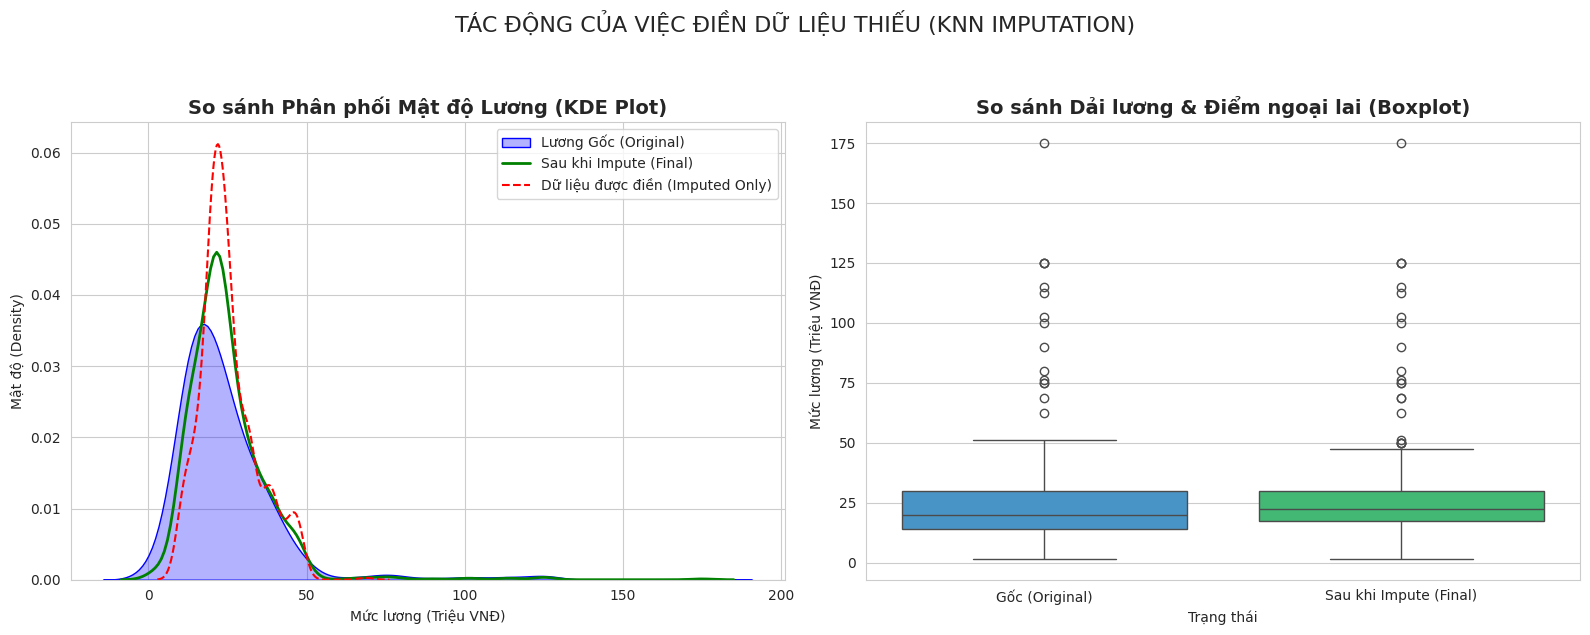


--- 📊 BẢNG SO SÁNH THỐNG KÊ ---


,Metric,Dữ liệu Gốc,Sau khi Impute
0,Mean (Trung bình),24.54,24.99
1,Median (Trung vị),20.00,22.50
2,Std (Độ lệch chuẩn),18.00,13.57
3,Min,1.50,1.50
4,Max,175.00,175.00


In [82]:
# --- VISUALIZATION: DISTRIBUTION BEFORE vs. AFTER IMPUTATION ---

# Cấu hình lại style cho đẹp
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- 1. KERNEL DENSITY ESTIMATE (KDE) - So sánh phân phối ---
# Vẽ phân phối dữ liệu gốc (Chỉ những dòng có lương)
sns.kdeplot(df['Avg_Salary'].dropna(), ax=ax[0], color='blue', label='Lương Gốc (Original)', fill=True, alpha=0.3)

# Vẽ phân phối dữ liệu sau khi điền (Toàn bộ dữ liệu)
sns.kdeplot(df['Avg_Salary_Imputed'], ax=ax[0], color='green', label='Sau khi Impute (Final)', linewidth=2)

# Vẽ riêng phân phối của những dòng được điền (Để xem KNN dự đoán thế nào)
imputed_only = df[df['Is_Imputed'] == True]['Avg_Salary_Imputed']
sns.kdeplot(imputed_only, ax=ax[0], color='red', label='Dữ liệu được điền (Imputed Only)', linestyle='--')

ax[0].set_title('So sánh Phân phối Mật độ Lương (KDE Plot)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Mức lương (Triệu VNĐ)')
ax[0].set_ylabel('Mật độ (Density)')
ax[0].legend()

# --- 2. BOXPLOT - So sánh thống kê (Trung vị, Outliers) ---
# Tạo DataFrame tạm để vẽ Boxplot dễ hơn
data_box = pd.DataFrame({
    'Lương': pd.concat([df['Avg_Salary'].dropna(), df['Avg_Salary_Imputed']]),
    'Trạng thái': ['Gốc (Original)'] * df['Avg_Salary'].notna().sum() + ['Sau khi Impute (Final)'] * len(df)
})

sns.boxplot(x='Trạng thái', y='Lương', data=data_box, palette=['#3498db', '#2ecc71'], ax=ax[1])

ax[1].set_title('So sánh Dải lương & Điểm ngoại lai (Boxplot)', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Mức lương (Triệu VNĐ)')

plt.suptitle('TÁC ĐỘNG CỦA VIỆC ĐIỀN DỮ LIỆU THIẾU (KNN IMPUTATION)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# --- THỐNG KÊ CHI TIẾT ---
print("\n--- 📊 BẢNG SO SÁNH THỐNG KÊ ---")
stats_comp = pd.DataFrame({
    'Metric': ['Mean (Trung bình)', 'Median (Trung vị)', 'Std (Độ lệch chuẩn)', 'Min', 'Max'],
    'Dữ liệu Gốc': [
        df['Avg_Salary'].mean(),
        df['Avg_Salary'].median(),
        df['Avg_Salary'].std(),
        df['Avg_Salary'].min(),
        df['Avg_Salary'].max()
    ],
    'Sau khi Impute': [
        df['Avg_Salary_Imputed'].mean(),
        df['Avg_Salary_Imputed'].median(),
        df['Avg_Salary_Imputed'].std(),
        df['Avg_Salary_Imputed'].min(),
        df['Avg_Salary_Imputed'].max()
    ]
})
display(stats_comp.round(2))

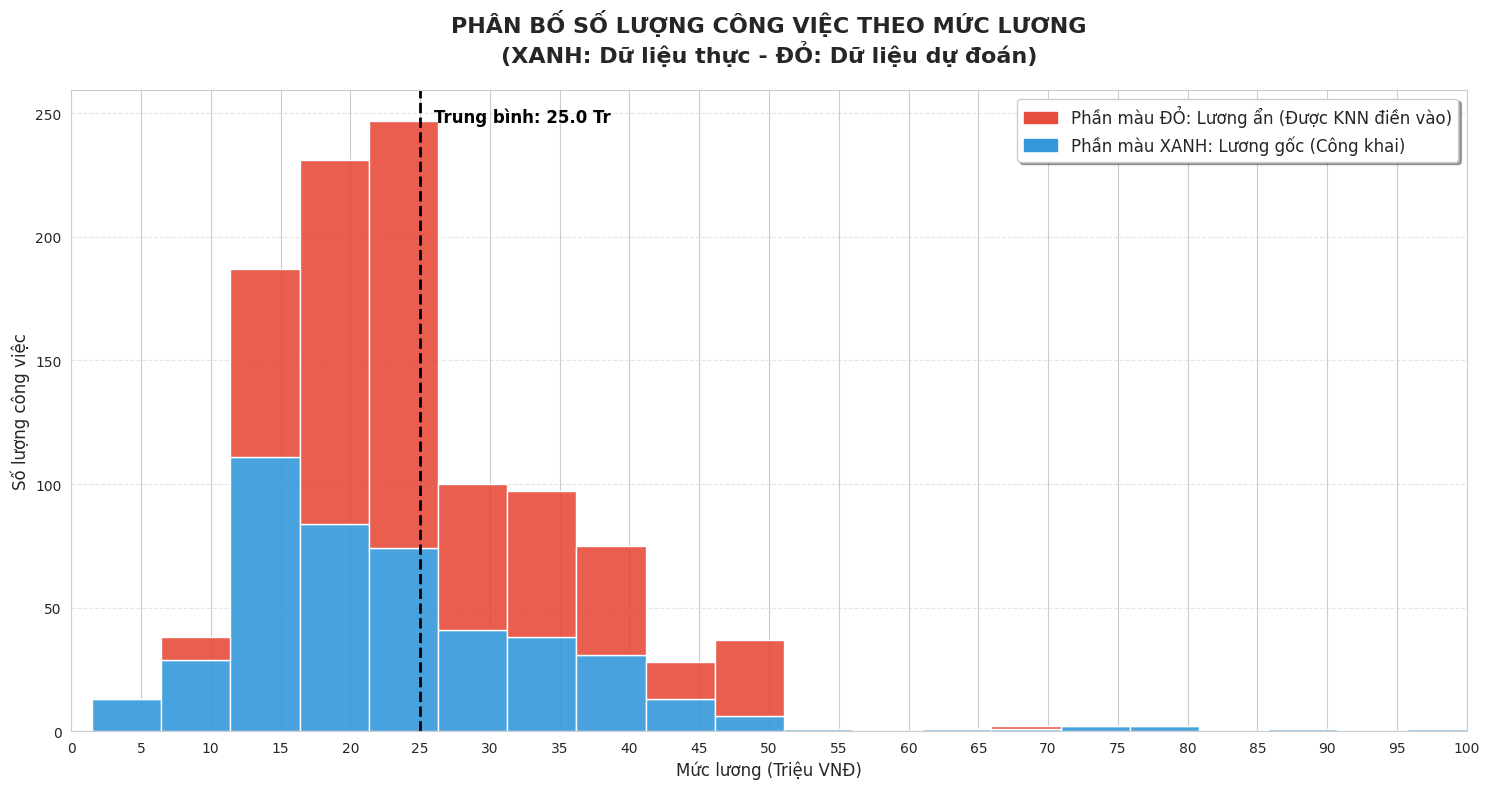

In [83]:
import matplotlib.patches as mpatches

# --- VISUALIZATION: STACKED HISTOGRAM (CÓ CHÚ THÍCH RÕ RÀNG) ---

plt.figure(figsize=(15, 8))

# 1. Chuẩn bị dữ liệu
plot_data = df.copy()
# Đặt tên rõ ràng để hiện lên Legend tự động
plot_data['Loại dữ liệu'] = plot_data['Is_Imputed'].apply(
    lambda x: 'Dữ liệu được điền (KNN)' if x else 'Dữ liệu gốc (Có sẵn)'
)

# 2. Vẽ biểu đồ Histogram chồng
# Lưu ý: hue_order để cố định màu đúng với nhãn
sns.histplot(
    data=plot_data,
    x='Avg_Salary_Imputed',
    hue='Loại dữ liệu',
    multiple='stack',
    binwidth=5,
    palette={'Dữ liệu được điền (KNN)': '#e74c3c', 'Dữ liệu gốc (Có sẵn)': '#3498db'}, # Đỏ - Xanh
    edgecolor='white',
    alpha=0.9,
    hue_order=['Dữ liệu được điền (KNN)', 'Dữ liệu gốc (Có sẵn)'] # Đảm bảo thứ tự chồng
)

# 3. Vẽ đường trung bình
mean_val = df['Avg_Salary_Imputed'].mean()
plt.axvline(mean_val, color='black', linestyle='--', linewidth=2)
# Thêm text cho đường trung bình thay vì legend
plt.text(mean_val + 1, plt.gca().get_ylim()[1]*0.95,
         f'Trung bình: {mean_val:.1f} Tr', color='black', fontweight='bold', fontsize=12)

# 4. TẠO CHÚ THÍCH (LEGEND) THỦ CÔNG & RÕ RÀNG
# Tạo các đối tượng màu để đưa vào khung chú thích
red_patch = mpatches.Patch(color='#e74c3c', label='Phần màu ĐỎ: Lương ẩn (Được KNN điền vào)')
blue_patch = mpatches.Patch(color='#3498db', label='Phần màu XANH: Lương gốc (Công khai)')

# Hiển thị bảng chú thích
plt.legend(handles=[red_patch, blue_patch], loc='upper right', fontsize=12, frameon=True, shadow=True)

# 5. Trang trí trục và tiêu đề
plt.title('PHÂN BỐ SỐ LƯỢNG CÔNG VIỆC THEO MỨC LƯƠNG\n(XANH: Dữ liệu thực - ĐỎ: Dữ liệu dự đoán)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Mức lương (Triệu VNĐ)', fontsize=12)
plt.ylabel('Số lượng công việc', fontsize=12)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 105, 5))
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

---
## 5. SQL WAREHOUSING (Lưu kho dữ liệu)
Thay vì lưu CSV, ta lưu vào **SQLite Database**. Đây là tiêu chuẩn khi làm việc với hệ thống lớn.

In [84]:
# Chọn các cột quan trọng để lưu
final_cols = ['Job Title', 'Company', 'Location', 'Avg_Salary_Imputed', 'Is_Imputed']
df_final = df_clean[final_cols]

# Đổi tên cột cho đẹp chuẩn SQL
df_final.columns = ['job_title', 'company', 'location', 'salary_million_vnd', 'is_imputed']

# Kết nối/Tạo database
db_name = "career_data.db"
conn = sqlite3.connect(db_name)

# Lưu vào bảng 'clean_jobs'
df_final.to_sql('clean_jobs', conn, if_exists='replace', index=False)

print(f"💾 Đã lưu thành công {len(df_final)} dòng vào database '{db_name}', bảng 'clean_jobs'.")

# Kiểm tra thử đọc lại 5 dòng từ SQL
check_df = pd.read_sql("SELECT * FROM clean_jobs LIMIT 5", conn)
display(check_df)

conn.close()

💾 Đã lưu thành công 1045 dòng vào database 'career_data.db', bảng 'clean_jobs'.


,job_title,company,location,salary_million_vnd,is_imputed
0,Trưởng nhóm Lập trình Java (tham gia các cuộc thi trong và ngoài nước về lập trình) (MỚI),Tổng Công ty Cổ phần Công trình Viettel,Hà Nội,35.0,0
1,Network Engineer - Kỹ Sư Mạng (Không Yêu Cầu Kinh Nghiệm),KDDI Vietnam - HCM GNOC (Ho Chi Minh Global Network Operations Center),Hồ Chí Minh,12.0,0
2,Quality Assurance Manager (Test Automation Manager),Công Ty CP Dược Phẩm Pharmacity,Hồ Chí Minh,25.6,1
3,ELV Engineer - Kỹ Sư Điện Nhẹ,Công Ty Cổ Phần Netcab,Hà Nội,14.0,0
4,Threat and Process Compliance Lead,Coca-Cola Beverages Vietnam,Hồ Chí Minh,20.3,1


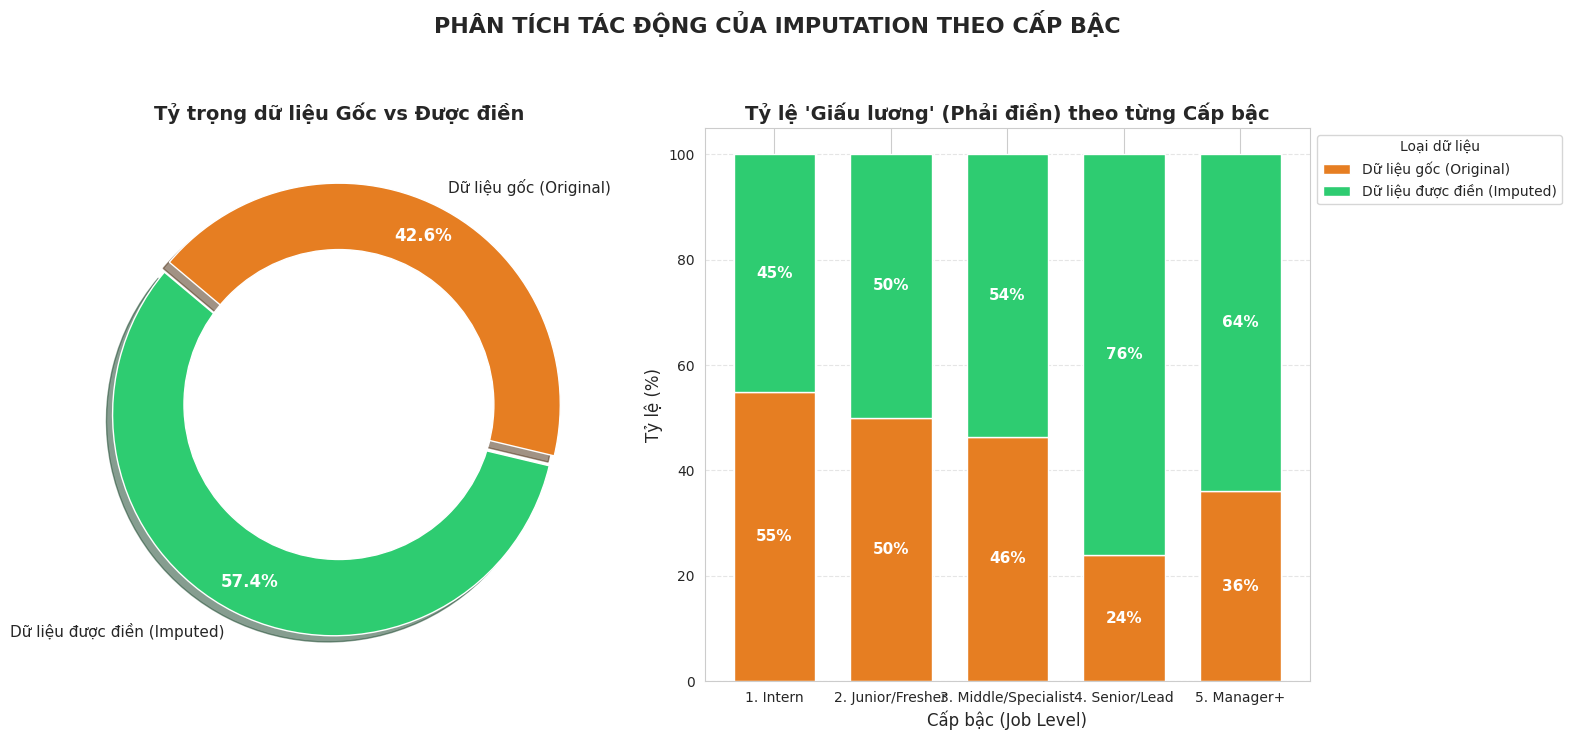


--- 📝 NHẬN XÉT TỪ DỮ LIỆU ---
1. Tổng quan: Có 614 vị trí đã được thuật toán KNN điền lương.
2. Xu hướng: Nhóm '4. Senior/Lead' có tỷ lệ giấu lương cao nhất (76.0%).
   -> Điều này cho thấy các vị trí này thường thỏa thuận lương thay vì công khai.


In [85]:
# --- PHÂN TÍCH CHI TIẾT DỮ LIỆU ĐƯỢC ĐIỀN (IMPUTED DATA ANALYSIS) ---

# 1. CHUẨN BỊ DỮ LIỆU (Feature Engineering nhẹ)
# Tạo cột phân loại trạng thái để hiển thị cho đẹp
df['Data_Type'] = df['Is_Imputed'].apply(lambda x: 'Dữ liệu được điền (Imputed)' if x else 'Dữ liệu gốc (Original)')

# Tạo cột Level (Cấp bậc) từ Job Title (Mấu chốt để biết vị trí nào bị điền nhiều nhất)
def detect_job_level(title):
    title = str(title).lower()
    if any(k in title for k in ['intern', 'thực tập', 'thuc tap', 'part time']): return '1. Intern'
    if any(k in title for k in ['fresher', 'junior', 'staff', 'mới tốt nghiệp', 'thử việc']): return '2. Junior/Fresher'
    if any(k in title for k in ['senior', 'lead', 'trưởng nhóm', 'principal', 'expert']): return '4. Senior/Lead'
    if any(k in title for k in ['manager', 'head', 'giám đốc', 'director', 'ceo', 'cto']): return '5. Manager+'
    return '3. Middle/Specialist' # Nhóm còn lại

df['Level_Category'] = df['Job Title'].apply(detect_job_level)

# 2. THIẾT LẬP BIỂU ĐỒ
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('PHÂN TÍCH TÁC ĐỘNG CỦA IMPUTATION THEO CẤP BẬC', fontsize=16, fontweight='bold', y=1.05)

# --- CHART 1: DONUT CHART (Tỷ lệ Tổng quan) ---
# Đếm số lượng
type_counts = df['Data_Type'].value_counts()
# Màu sắc: Xanh (Gốc) - Đỏ cam (Imputed)
colors = ['#2ecc71', '#e67e22']

wedges, texts, autotexts = ax[0].pie(type_counts, labels=type_counts.index, autopct='%1.1f%%',
                                     startangle=140, colors=colors, pctdistance=0.85,
                                     explode=[0.05, 0], shadow=True)

# Tạo lỗ tròn
centre_circle = plt.Circle((0,0), 0.70, fc='white')
ax[0].add_artist(centre_circle)

# Style text
ax[0].set_title("Tỷ trọng dữ liệu Gốc vs Được điền", fontsize=14, fontweight='bold')
plt.setp(autotexts, size=12, weight="bold", color="white")
plt.setp(texts, size=11)

# --- CHART 2: 100% STACKED BAR CHART (Theo Level) ---
# Pivot: Hàng là Level, Cột là Loại dữ liệu
pivot_data = df.groupby(['Level_Category', 'Data_Type']).size().unstack(fill_value=0)

# Tính phần trăm (Normalize 100% theo hàng ngang)
pivot_pct = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Vẽ biểu đồ chồng
pivot_pct.plot(kind='bar', stacked=True, color=['#e67e22', '#2ecc71'], ax=ax[1], width=0.7)

# Trang trí Chart 2
ax[1].set_title("Tỷ lệ 'Giấu lương' (Phải điền) theo từng Cấp bậc", fontsize=14, fontweight='bold')
ax[1].set_xlabel('Cấp bậc (Job Level)', fontsize=12)
ax[1].set_ylabel('Tỷ lệ (%)', fontsize=12)
ax[1].tick_params(axis='x', rotation=0)
ax[1].legend(title='Loại dữ liệu', bbox_to_anchor=(1, 1))
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

# Thêm nhãn số % vào giữa các cột
for c in ax[1].containers:
    # Chỉ hiện nhãn nếu cột đó đủ lớn (>5%) để tránh rối
    labels = [f'{v.get_height():.0f}%' if v.get_height() > 5 else '' for v in c]
    ax[1].bar_label(c, labels=labels, label_type='center', color='white', weight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# --- 3. IN RA NHẬN XÉT TỰ ĐỘNG ---
print("\n--- 📝 NHẬN XÉT TỪ DỮ LIỆU ---")
# Tìm level bị điền nhiều nhất (Tỷ lệ Imputed cao nhất)
highest_imputed_level = pivot_pct['Dữ liệu được điền (Imputed)'].idxmax()
highest_imputed_val = pivot_pct['Dữ liệu được điền (Imputed)'].max()

print(f"1. Tổng quan: Có {type_counts['Dữ liệu được điền (Imputed)']:,} vị trí đã được thuật toán KNN điền lương.")
print(f"2. Xu hướng: Nhóm '{highest_imputed_level}' có tỷ lệ giấu lương cao nhất ({highest_imputed_val:.1f}%).")
print("   -> Điều này cho thấy các vị trí này thường thỏa thuận lương thay vì công khai.")

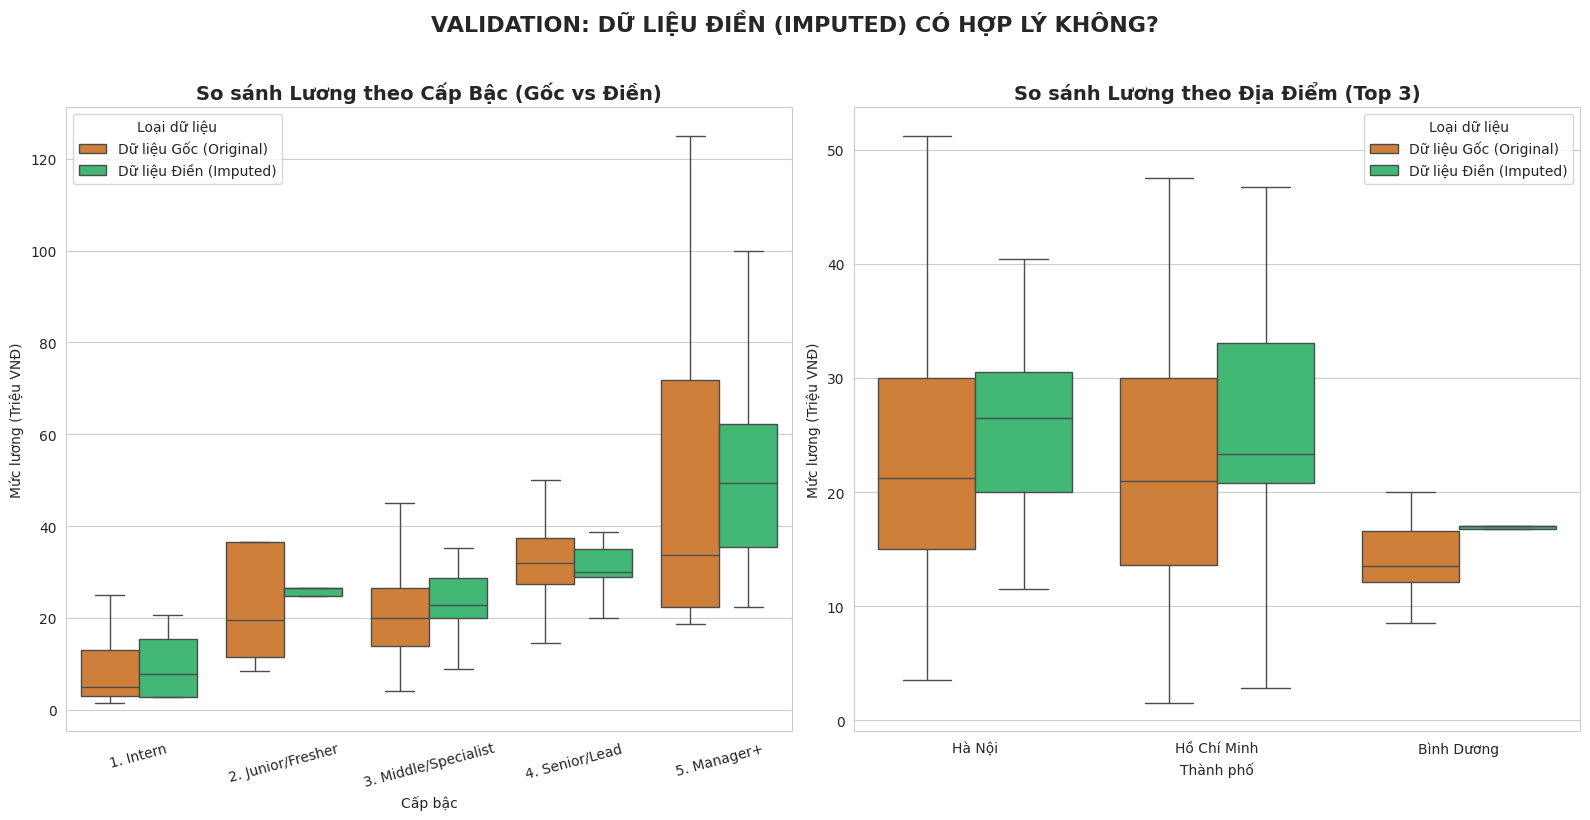


--- 🕵️‍♂️ KIỂM TRA LOGIC TỰ ĐỘNG ---
Nguyên tắc: Trung vị lương của dữ liệu ĐIỀN không được lệch quá xa so với dữ liệu GỐC trong cùng một nhóm.

🔹 1. Intern: Gốc=5.0Tr | Điền=7.8Tr | Chênh lệch: +2.8Tr -> ✅ Hợp lý
🔹 2. Junior/Fresher: Gốc=19.5Tr | Điền=26.5Tr | Chênh lệch: +7.0Tr -> ⚠️ Cần xem lại
🔹 3. Middle/Specialist: Gốc=20.0Tr | Điền=22.9Tr | Chênh lệch: +2.9Tr -> ✅ Hợp lý
🔹 4. Senior/Lead: Gốc=31.9Tr | Điền=30.1Tr | Chênh lệch: -1.8Tr -> ✅ Hợp lý
🔹 5. Manager+: Gốc=33.8Tr | Điền=49.5Tr | Chênh lệch: +15.7Tr -> ⚠️ Cần xem lại


In [96]:
# --- VALIDATION: KIỂM TRA TÍNH HỢP LÝ CỦA DỮ LIỆU ĐƯỢC ĐIỀN (LOGIC CHECK) ---

# 1. Cấu hình chung
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

# Tạo cột Data_Type để phân màu (nếu chưa có)
df['Data_Type'] = df['Is_Imputed'].apply(lambda x: 'Dữ liệu Điền (Imputed)' if x else 'Dữ liệu Gốc (Original)')

# --- CHART 1: SO SÁNH LƯƠNG THEO CẤP BẬC (LEVEL) ---
plt.subplot(1, 2, 1)

# Sắp xếp thứ tự Level để biểu đồ dễ nhìn logic tăng dần
level_order = ['1. Intern', '2. Junior/Fresher', '3. Middle/Specialist', '4. Senior/Lead', '5. Manager+']

sns.boxplot(data=df, x='Level_Category', y='Avg_Salary_Imputed', hue='Data_Type',
            order=level_order, palette={'Dữ liệu Gốc (Original)': '#e67e22', 'Dữ liệu Điền (Imputed)': '#2ecc71'},
            showfliers=False) # Ẩn bớt điểm ngoại lai quá xa để nhìn rõ hộp chính

plt.title('So sánh Lương theo Cấp Bậc (Gốc vs Điền)', fontsize=14, fontweight='bold')
plt.xlabel('Cấp bậc')
plt.ylabel('Mức lương (Triệu VNĐ)')
plt.xticks(rotation=15)
plt.legend(title='Loại dữ liệu', loc='upper left')


# --- CHART 2: SO SÁNH LƯƠNG THEO ĐỊA ĐIỂM (TOP 3 LOCATION) ---
# (Vì lương ở HCM/HN thường cao hơn tỉnh lẻ, cần xem KNN có học được điều này không)
plt.subplot(1, 2, 2)

# Lấy Top 3 thành phố lớn nhất để so sánh cho gọn
top_locations = df['Location'].value_counts().nlargest(3).index
df_top_loc = df[df['Location'].isin(top_locations)]

sns.boxplot(data=df_top_loc, x='Location', y='Avg_Salary_Imputed', hue='Data_Type',
            palette={'Dữ liệu Gốc (Original)': '#e67e22', 'Dữ liệu Điền (Imputed)': '#2ecc71'},
            showfliers=False)

plt.title('So sánh Lương theo Địa Điểm (Top 3)', fontsize=14, fontweight='bold')
plt.xlabel('Thành phố')
plt.ylabel('Mức lương (Triệu VNĐ)')
plt.legend(title='Loại dữ liệu', loc='upper right')

plt.suptitle('VALIDATION: DỮ LIỆU ĐIỀN (IMPUTED) CÓ HỢP LÝ KHÔNG?', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- CHECK LOGIC TỰ ĐỘNG ---
print("\n--- 🕵️‍♂️ KIỂM TRA LOGIC TỰ ĐỘNG ---")
print("Nguyên tắc: Trung vị lương của dữ liệu ĐIỀN không được lệch quá xa so với dữ liệu GỐC trong cùng một nhóm.\n")

for level in level_order:
    # Lấy dữ liệu từng nhóm
    subset = df[df['Level_Category'] == level]

    # Tính trung vị (Median)
    median_orig = subset[subset['Is_Imputed'] == False]['Avg_Salary_Imputed'].median()
    median_imp = subset[subset['Is_Imputed'] == True]['Avg_Salary_Imputed'].median()

    # So sánh
    if pd.isna(median_orig) or pd.isna(median_imp):
        print(f"⚠️ {level}: Không đủ dữ liệu để so sánh.")
        continue

    diff = median_imp - median_orig
    status = "✅ Hợp lý" if abs(diff) < 5 else "⚠️ Cần xem lại" # Chênh lệch < 5 triệu là chấp nhận được

    print(f"🔹 {level}: Gốc={median_orig:.1f}Tr | Điền={median_imp:.1f}Tr | Chênh lệch: {diff:+.1f}Tr -> {status}")